# CSE527 Homework 3
**Due date: 23:59 on 11/06, 2018 (Tuesday)**

## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 15 categories by training and testing on the 15
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---
The starter code trains and tests on 100 images from each category (i.e. 1500
training examples total and 1500 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.
Download the dataset
[here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing). <br>

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder,
there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Delete** the data subfolder before submission or the blackboard won't let you do so because
of the size. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.6% accuracy
(1 out of 15 guesses is correct).

In [2]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import time

In [4]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset('data/test/', 100)
test_num = len(test_label)

# feature extraction
def extract_feat(raw_data):
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
        
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(15) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in xrange(test_num):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(test_num)

print "The accuracy of my dummy model is {:.2f}%".format(accuracy*100)

The accuracy of my dummy model is 6.67%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [5]:
# Write your codes here
import copy 
from sklearn.neighbors import KNeighborsClassifier
from scipy.misc import imresize


# resize images
def resize_images(data, dimension):
    resized = copy.deepcopy(data)
    s = np.zeros((len(resized), dimension*dimension))
    for i in range(0, len(data)):
        resized[i] = imresize(data[i], (dimension, dimension))        
        s[i,:] = np.reshape(resized[i], (1,dimension*dimension))
    return s

train_resized = resize_images(train_data, 16)
test_resized = resize_images(test_data, 16)


# k-nearest neighbor
def train_knn(data, label, k):
    neigh = KNeighborsClassifier(n_neighbors=k, p=2)
    neigh.fit(data, label) 
    return neigh


# test for different cluster sizes and print the accuracy
cluster_sizes = np.arange(5,65,5)
for i in range(len(cluster_sizes)):
    t0 = time.time()
    model = train_knn(train_resized, train_label, cluster_sizes[i])
    predict_test = model.predict(test_resized)
    t1 = time.time()
    print "k =", cluster_sizes[i], ";\t Accuracy =", round(np.mean(predict_test == test_label)*100,3), "% ;\t Train+Test Time taken =", round(t1-t0,3)
    
    
# function to do the above for best k 
def train_and_test(train_data, train_label, test_data, test_label, k):
    t0 = time.time()
    train_resized = resize_images(train_data, 16)
    test_resized = resize_images(test_data, 16)
    model = train_knn(train_resized, train_label, k)
    t1 = time.time()
    print "Train time (seconds) : ", round(t1-t0,3)
    t2 = time.time()
    predict_test = model.predict(test_resized)
    t3 = time.time()
    print "Test time (seconds) : ", round(t3-t2, 3)
    return (predict_test, test_label)

print "===========\n"
pred1, label1 = train_and_test(train_data, train_label, test_data, test_label, k=15)
print "K=15 ;\tAccuracy=",round(np.mean(pred1 == label1)*100, 3) 


k = 5 ;	 Accuracy = 19.733 % ;	 Train+Test Time taken = 1.228
k = 10 ;	 Accuracy = 20.133 % ;	 Train+Test Time taken = 0.929
k = 15 ;	 Accuracy = 20.667 % ;	 Train+Test Time taken = 0.958
k = 20 ;	 Accuracy = 19.867 % ;	 Train+Test Time taken = 0.971
k = 25 ;	 Accuracy = 19.933 % ;	 Train+Test Time taken = 1.897
k = 30 ;	 Accuracy = 19.733 % ;	 Train+Test Time taken = 0.994
k = 35 ;	 Accuracy = 19.0 % ;	 Train+Test Time taken = 0.968
k = 40 ;	 Accuracy = 18.933 % ;	 Train+Test Time taken = 0.951
k = 45 ;	 Accuracy = 18.533 % ;	 Train+Test Time taken = 0.915
k = 50 ;	 Accuracy = 18.6 % ;	 Train+Test Time taken = 0.954
k = 55 ;	 Accuracy = 19.067 % ;	 Train+Test Time taken = 0.956
k = 60 ;	 Accuracy = 18.933 % ;	 Train+Test Time taken = 0.931

Train time (seconds) :  0.631
Test time (seconds) :  0.894
K=15 ;	Accuracy= 20.667


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [7]:
# Write your codes here
from sklearn.cluster import KMeans
from sklearn import preprocessing
import cPickle
import os.path

# computing dense SIFT features
def compute_SIFT(data):
    result = []
    for i in range(0, len(data)):
        sift = cv2.xfeatures2d.SIFT_create()
        image_i = data[i]
        step_size = 15
        keypoints = [cv2.KeyPoint(x, y, step_size) for x in range(0, image_i.shape[0], step_size) for y in range(0, image_i.shape[1], step_size)]
        dense_features = sift.compute(image_i, keypoints)
        result.append(dense_features[1])
    return result


# extracting dense SIFT features from training images
xtrain = compute_SIFT(train_data)
xtest = compute_SIFT(test_data)

train_desc = []
for i in range(len(xtrain)):
    for j in range(xtrain[i].shape[0]):
        train_desc.append(xtrain[i][j,:])
train_desc = np.array(train_desc)


def form_histogram_from_train_data(xtrain, kmeans, k):
    train_histogram = []
    for i in range(len(xtrain)):
        data_i = copy.deepcopy(xtrain[i])
        predictions = kmeans.predict(data_i)
        train_histogram.append(np.bincount(predictions, minlength=k).reshape(1,-1).ravel())  
    return np.array(train_histogram)


def predict_test_data_kmeans(kmeans, normalizer, xtest, train_histogram, train_label, k):
    test_histogram = form_histogram_from_train_data(xtest, kmeans, k)
    test_histogram = normalizer.transform(test_histogram)
    knn_model = train_knn(train_histogram, train_label, k)
    predictions = knn_model.predict(test_histogram)
    typeof = np.array([test_label]).dtype
    return np.array([predictions], dtype=typeof)


cluster_sizes = np.arange(10,80,5)
for i in range(len(cluster_sizes)):
    t0 = time.time()
    if not os.path.isfile('kmeans_'+str(cluster_sizes[i])+'.p'):
        kmeans = KMeans(n_clusters=cluster_sizes[i], random_state=0).fit(train_desc)
        cPickle.dump(kmeans, open('kmeans_'+str(cluster_sizes[i])+'.p', 'wb'))
    else:
        kmeans = cPickle.load(open('kmeans_'+str(cluster_sizes[i])+'.p', 'rb'))
    train_histogram = form_histogram_from_train_data(xtrain, kmeans, cluster_sizes[i])
    normalizer = preprocessing.StandardScaler().fit(train_histogram)
    train_histogram = normalizer.transform(train_histogram)
    test_pred = predict_test_data_kmeans(kmeans, normalizer, xtest, train_histogram, train_label, cluster_sizes[i])
    predictions = np.array(test_pred.tolist()[0])
    groundtruth = np.array(test_label)
    accuracy = np.mean(predictions == groundtruth)
    t1 = time.time()
    print "k =", cluster_sizes[i], ";\t Accuracy =", round(accuracy*100,3), "% ;\t Time taken =", round(t1-t0,3)

    
def train_and_test(train_desc, xtrain, train_label, xtest, test_label, k):
    if not os.path.isfile('kmeans_'+str(k)+'.p'):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(train_desc)
        cPickle.dump(kmeans, open('kmeans_'+str(k)+'.p', 'wb'))
    else:
        kmeans = cPickle.load(open('kmeans_'+str(k)+'.p', 'rb'))
    train_histogram = form_histogram_from_train_data(xtrain, kmeans, k)
    normalizer = preprocessing.StandardScaler().fit(train_histogram)
    train_histogram = normalizer.transform(train_histogram)
    test_pred = predict_test_data_kmeans(kmeans, normalizer, xtest, train_histogram, train_label, k)
    predictions = np.array(test_pred.tolist()[0])
    groundtruth = np.array(test_label)
    return (predictions, groundtruth)
    
t0 = time.time()
pred2, label2 = train_and_test(train_desc, xtrain, train_label, xtest, test_label, k=60)
t1 = time.time()
print "===========\nBest : K=60 ;\t Accuracy =", round(np.mean(pred2 == label2)*100,3), "% ;\t Time taken =", round(t1-t0,3)

k = 10 ;	 Accuracy = 50.533 % ;	 Time taken = 147.983
k = 15 ;	 Accuracy = 52.667 % ;	 Time taken = 210.069
k = 20 ;	 Accuracy = 51.8 % ;	 Time taken = 344.177
k = 25 ;	 Accuracy = 53.667 % ;	 Time taken = 455.398
k = 30 ;	 Accuracy = 55.733 % ;	 Time taken = 498.699
k = 35 ;	 Accuracy = 58.0 % ;	 Time taken = 674.169
k = 40 ;	 Accuracy = 59.467 % ;	 Time taken = 644.912
k = 45 ;	 Accuracy = 60.133 % ;	 Time taken = 749.061
k = 50 ;	 Accuracy = 59.6 % ;	 Time taken = 786.836
k = 55 ;	 Accuracy = 59.667 % ;	 Time taken = 840.212
k = 60 ;	 Accuracy = 61.4 % ;	 Time taken = 982.1
k = 65 ;	 Accuracy = 60.733 % ;	 Time taken = 1033.512
k = 70 ;	 Accuracy = 59.867 % ;	 Time taken = 1138.099
k = 75 ;	 Accuracy = 61.133 % ;	 Time taken = 1164.507
Best : K=60 ;	 Accuracy = 61.4 % ;	 Time taken = 5.897


### For the last line, K=60, we dont do Kmeans again, we load the saved model and evaluate. Hence, in the last line we have less time of ~ 6 seconds,, while if we do Kmeans, we get total (train+test) time of 982 seconds ~ 17 minutes (as seen in the iterations).

### Below we individually time the "testing" part. We see the testing time is ~ 1 seconds. So we infer : Train time ~ 17 minutes ; Test time ~ 1 second ; For K=60

In [17]:
# timing the test part
def train_and_test(train_desc, xtrain, train_label, xtest, test_label, k):
    if not os.path.isfile('kmeans_'+str(k)+'.p'):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(train_desc)
        cPickle.dump(kmeans, open('kmeans_'+str(k)+'.p', 'wb'))
    else:
        kmeans = cPickle.load(open('kmeans_'+str(k)+'.p', 'rb'))
    train_histogram = form_histogram_from_train_data(xtrain, kmeans, k)
    normalizer = preprocessing.StandardScaler().fit(train_histogram)
    train_histogram = normalizer.transform(train_histogram)
    t0 = time.time()
    test_pred = predict_test_data_kmeans(kmeans, normalizer, xtest, train_histogram, train_label, k)
    t1 = time.time()
    print "==== Test time (seconds) : ", round(t1-t0, 3)
    predictions = np.array(test_pred.tolist()[0])
    groundtruth = np.array(test_label)
    return (predictions, groundtruth)
    

pred2_a, label2_a = train_and_test(train_desc, xtrain, train_label, xtest, test_label, k=60)
print "===========\nBest : K=60 ;\t Accuracy =", round(np.mean(pred2 == label2)*100,3)

==== Test time (seconds) :  1.041
Best : K=60 ;	 Accuracy = 61.4


## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{20 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 15-way classification problem
(the library has handled it for you). To decide which of 15 categories a test
case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: 10 points will be given to students whose accuracy
  ranks top 3 in this homework. Don't cheat and don't train your model on
  testing data, a separate testing dataset will be used to evaluate your model.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [18]:
# Write your codes here
from sklearn.svm import LinearSVC

k = 60
if not os.path.isfile('kmeans_'+str(k)+'.p'):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(train_desc)
    cPickle.dump(kmeans, open('kmeans_'+str(k)+'.p', 'wb'))
else:
    kmeans = cPickle.load(open('kmeans_'+str(k)+'.p', 'rb'))
train_histogram = form_histogram_from_train_data(xtrain, kmeans, k)
test_histogram = form_histogram_from_train_data(xtest, kmeans, k)
normalizer = preprocessing.StandardScaler().fit(train_histogram)
train_histogram = normalizer.transform(train_histogram)
test_histogram = normalizer.transform(test_histogram)

for c_value in np.arange(0.0001, 0.2, 0.002):
    classifier = LinearSVC(random_state=0, C=c_value)
    classifier.fit(train_histogram, train_label)
    test_pred = classifier.predict(test_histogram)
    print "C =", round(c_value,5), ": Accuracy =", round(np.mean(test_pred == test_label)*100,4), "%"


def train_and_test(train_desc, xtrain, train_label, xtest, test_label, c_value):
    if not os.path.isfile('kmeans_'+str(k)+'.p'):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(train_desc)
        cPickle.dump(kmeans, open('kmeans_'+str(k)+'.p', 'wb'))
    else:
        kmeans = cPickle.load(open('kmeans_'+str(k)+'.p', 'rb'))
    train_histogram = form_histogram_from_train_data(xtrain, kmeans, k)
    test_histogram = form_histogram_from_train_data(xtest, kmeans, k)
    normalizer = preprocessing.StandardScaler().fit(train_histogram)
    train_histogram = normalizer.transform(train_histogram)
    test_histogram = normalizer.transform(test_histogram)
    classifier = LinearSVC(random_state=0, C=c_value)
    classifier.fit(train_histogram, train_label)
    t0 = time.time()
    test_pred = classifier.predict(test_histogram)
    t1 = time.time()
    print "Test time (seconds) : ", round(t1-t0,3)
    return (test_pred, test_label)


print "===========\n"
t0 = time.time()
c_value=0.1740
pred3, label3 = train_and_test(train_desc, xtrain, train_label, xtest, test_label, c_value)
t1 = time.time()
print "Best : K=60 ;\tC=", c_value, ";\tAccuracy=",round(np.mean(pred3 == label3)*100, 3) ,";\t Train+Test Time taken=", round(t1-t0,3)

C = 0.0001 : Accuracy = 57.6 %
C = 0.0021 : Accuracy = 61.9333 %
C = 0.0041 : Accuracy = 63.4 %
C = 0.0061 : Accuracy = 64.8667 %
C = 0.0081 : Accuracy = 65.2 %
C = 0.0101 : Accuracy = 65.2 %
C = 0.0121 : Accuracy = 65.4667 %
C = 0.0141 : Accuracy = 65.8 %
C = 0.0161 : Accuracy = 66.0 %
C = 0.0181 : Accuracy = 66.0667 %
C = 0.0201 : Accuracy = 66.0667 %
C = 0.0221 : Accuracy = 66.1333 %
C = 0.0241 : Accuracy = 66.0 %
C = 0.0261 : Accuracy = 66.0 %
C = 0.0281 : Accuracy = 66.1333 %
C = 0.0301 : Accuracy = 66.1333 %
C = 0.0321 : Accuracy = 66.3333 %
C = 0.0341 : Accuracy = 66.4 %
C = 0.0361 : Accuracy = 66.5333 %
C = 0.0381 : Accuracy = 66.5333 %
C = 0.0401 : Accuracy = 66.5333 %
C = 0.0421 : Accuracy = 66.6667 %
C = 0.0441 : Accuracy = 66.8 %
C = 0.0461 : Accuracy = 66.8667 %
C = 0.0481 : Accuracy = 67.0 %
C = 0.0501 : Accuracy = 67.1333 %
C = 0.0521 : Accuracy = 67.2 %
C = 0.0541 : Accuracy = 67.2 %
C = 0.0561 : Accuracy = 67.2 %
C = 0.0581 : Accuracy = 67.5333 %
C = 0.0601 : Accuracy 

### Even in this part, we didnot run the Kmeans again for K=60,, we just load the previously saved model and use it. Hence, we save time by not running Kmeans again.

## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%). <br>

### **First combination:** 
#### -- Time consumed and prediction accuracy
<pre>
k = 05 ;	 Accuracy = 19.733 % 
k = 10 ;	 Accuracy = 20.133 % 
k = 15 ;	 Accuracy = 20.667 % 
k = 20 ;	 Accuracy = 19.867 % 
k = 25 ;	 Accuracy = 19.933 % 
k = 30 ;	 Accuracy = 19.733 % 
k = 35 ;	 Accuracy = 19.000 % 
k = 40 ;	 Accuracy = 18.933 % 
k = 45 ;	 Accuracy = 18.533 % 
k = 50 ;	 Accuracy = 18.600 % 
k = 55 ;	 Accuracy = 19.067 % 
k = 60 ;	 Accuracy = 18.933 % 
===========
</pre>
<pre style="color:blue">
(1) BEST RESULT : K=15 ;  Accuracy= 20.667 % ;  Train time :  0.631 seconds ;  Test time :  0.894 seconds
</pre>
#### -- Algorithm descriptions and discussions
We consider features of images as raw pixels. Each training image has its raw pixels that are reshaped from 2D dimension into 1D dimensional vector by concatenating all the rows of an image into one vector. This vector then represent the feature vector for that image. The training set has size of MxN, where M is the number of training samples, N is length of each feature vector. The test set can be formed in a similar way.<br>
I used K-nearest neighbor algorithm. The KNN computes the distances (using L2/Euclidean distances norm) from each test image to all training images and pick K shortest distances and assigns label for the test image based on voting mechanism. Intuitively, we achieve better performance for higher K values since higher K makes classifier resistant to outliers.

#### -- Confusion matrix observations
The Normalized form of confusion matrix gives us the accuracy of prediction for each class. We evaluate the performance by looking at the diagonal of the matrix, the higher the value along the diagonal, the better is the  performance.<br>
Since the features used in this problem are raw pixels of Tiny Images, they're not a good representation to capture the important information in the image, which causes poor performance on the prediction on the new test images. It can be seen from the diagonal of confusion matrix. 

=============================================================================================================

<br> 
### **Second combination:** 

#### -- Time consumed and prediction accuracy
<pre>
k = 10 ;     Accuracy = 50.533 % ;     Train+Test Time taken = 147.983 seconds
k = 15 ;     Accuracy = 52.667 % ;     Train+Test Time taken = 210.069 seconds
k = 20 ;     Accuracy = 51.800 % ;     Train+Test Time taken = 344.177 seconds
k = 25 ;     Accuracy = 53.667 % ;     Train+Test Time taken = 455.398 seconds
k = 30 ;     Accuracy = 55.733 % ;     Train+Test Time taken = 498.699 seconds
k = 35 ;     Accuracy = 58.000 % ;     Train+Test Time taken = 674.169 seconds
k = 40 ;     Accuracy = 59.467 % ;     Train+Test Time taken = 644.912 seconds
k = 45 ;     Accuracy = 60.133 % ;     Train+Test Time taken = 749.061 seconds
k = 50 ;     Accuracy = 59.600 % ;     Train+Test Time taken = 786.836 seconds
k = 55 ;     Accuracy = 59.667 % ;     Train+Test Time taken = 840.212 seconds
k = 60 ;     Accuracy = 61.400 % ;     Train+Test Time taken = 982.100 seconds
k = 65 ;     Accuracy = 60.733 % ;     Train+Test Time taken = 1033.512 seconds
k = 70 ;     Accuracy = 59.867 % ;     Train+Test Time taken = 1138.099 seconds
k = 75 ;     Accuracy = 61.133 % ;     Train+Test Time taken = 1164.507 seconds
===========
</pre>
<pre style="color:blue">
(2) BEST RESULT : K=60 ;  Accuracy = 61.4 % ;  Train Time ~ 17 minutes ;  Test Time ~ 1 second
</pre>

#### -- Algorithm descriptions and discussions
We now represent features in the images by using Bag of Words (BoW) model. <br>
1. Extract dense SIFT features from training images  
2. Build Bag of Words representation from SIFT of training images using Kmeans.
3. Save the Kmeans model
3. Form training set histograms for each train image using BoW representation (load the Kmeans model and predict on training images)
4. Form histograms for test set as test data
5. Make testing histograms zero mean and unit variance
6. Train model using KNN (train on training_histogram and predict on test_histogram)

One of the drawbacks of using KNN or K-means is that we have to determine the value of K. I tried different values of K as mentioned above.<br>
One drawback of Bag of Visual Words is, all local features are encoded into a single code vector which means spatial information between words are lost in the final code vector.


#### -- Confusion matrix observations
The Normalized form of confusion matrix gives us the accuracy of prediction for each class. We evaluate the performance by looking at the diagonal of the matrix, the higher the value along the diagonal, the better is the  performance. We see decent values for accuracy along the diagonal. Better than what we saw in Approach 1.

=============================================================================================================

### **Third combination:**

#### -- Time consumed and prediction accuracy
<pre>
C = 0.1621 : Accuracy = 69.1333 %
C = 0.1641 : Accuracy = 69.0667 %
C = 0.1661 : Accuracy = 69.0667 %
C = 0.1681 : Accuracy = 69.2000 %
C = 0.1701 : Accuracy = 69.2667 %
C = 0.1721 : Accuracy = 69.3333 %
C = 0.1741 : Accuracy = 69.3333 %
C = 0.1761 : Accuracy = 69.3333 %
C = 0.1781 : Accuracy = 69.3333 %
C = 0.1801 : Accuracy = 69.2667 %
C = 0.1821 : Accuracy = 69.2000 %
C = 0.1841 : Accuracy = 69.1333 %
C = 0.1861 : Accuracy = 69.0667 %
C = 0.1881 : Accuracy = 69.0667 %
C = 0.1901 : Accuracy = 69.0000 %
C = 0.1921 : Accuracy = 69.0667 %
C = 0.1941 : Accuracy = 69.1333 %
C = 0.1961 : Accuracy = 69.1333 %
C = 0.1981 : Accuracy = 69.1333 %
===========
Note that we do not run Kmeans for K=60, we just load the previously saved model and use it.
</pre>
<pre style="color:blue"> 
(3) BEST RESULT : K=60 ;  C= 0.174 ;  Accuracy= 69.333 % ;  Train Time ~ 2.036 sec ;  Test Time ~ 0.001 sec
</pre>

#### -- Algorithm descriptions and discussions
This is similar to problem 2, just that after constructing the train_histogram and test_histogram, instead of classifying using KNN, we use Support Vector Machine (SVM). sklearn's LinearSVC has multiclass support and it is  handled according to a one-vs-the-rest scheme. SVM will try to find linearly separable plane using support vectors, while KNN can be non-linear and very sensitive to outliers.  I tried different values for C as reported above.

#### -- Confusion matrix observations
The Normalized form of confusion matrix gives us the accuracy of prediction for each class. We evaluate the performance by looking at the diagonal of the matrix, the higher the value along the diagonal, the better is the  performance. We see overall best performance using approach 3. SVM (approach 3) performs better than KNN (approach 2).


=============================================================================================================

### Along with .ipynb, i am attaching the Kmeans model files saved in cPickle format, tried for different cluster sizes (from problem 2)

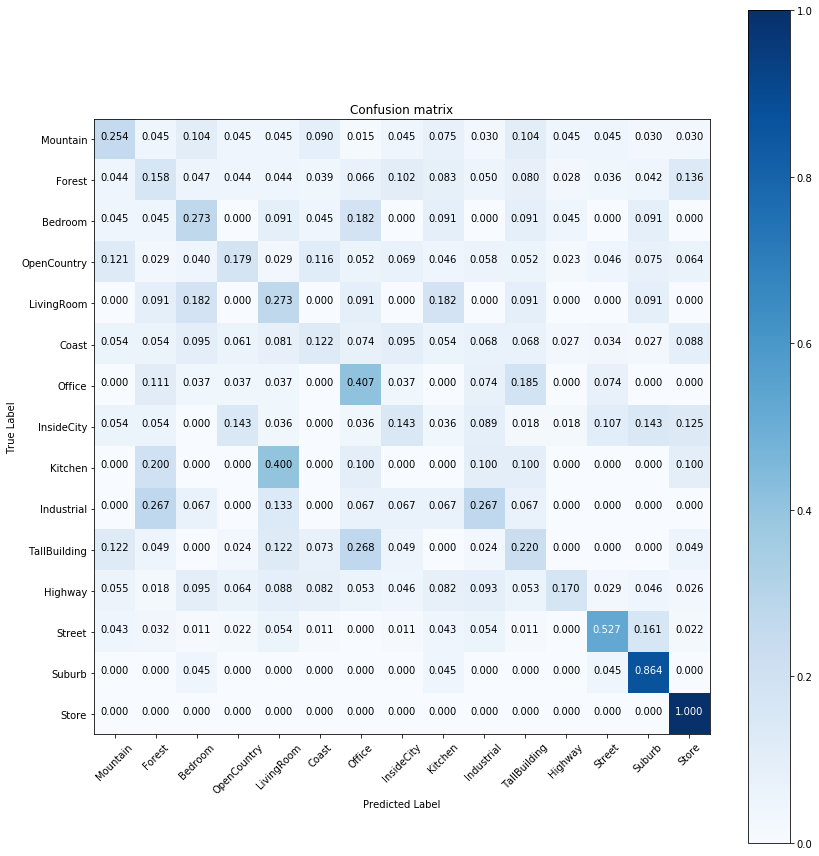

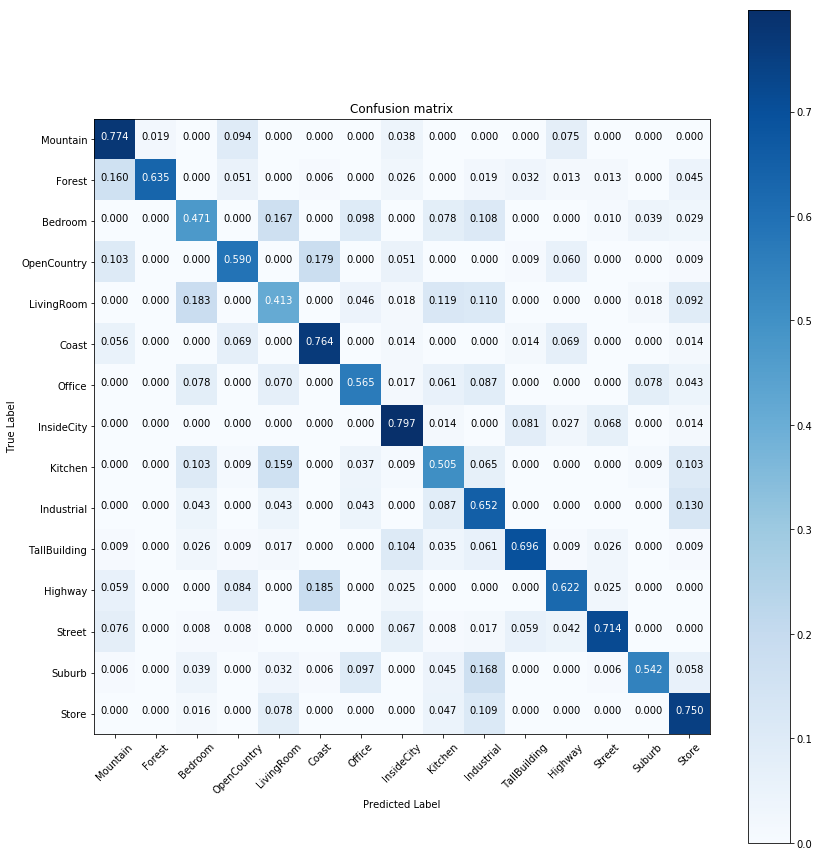

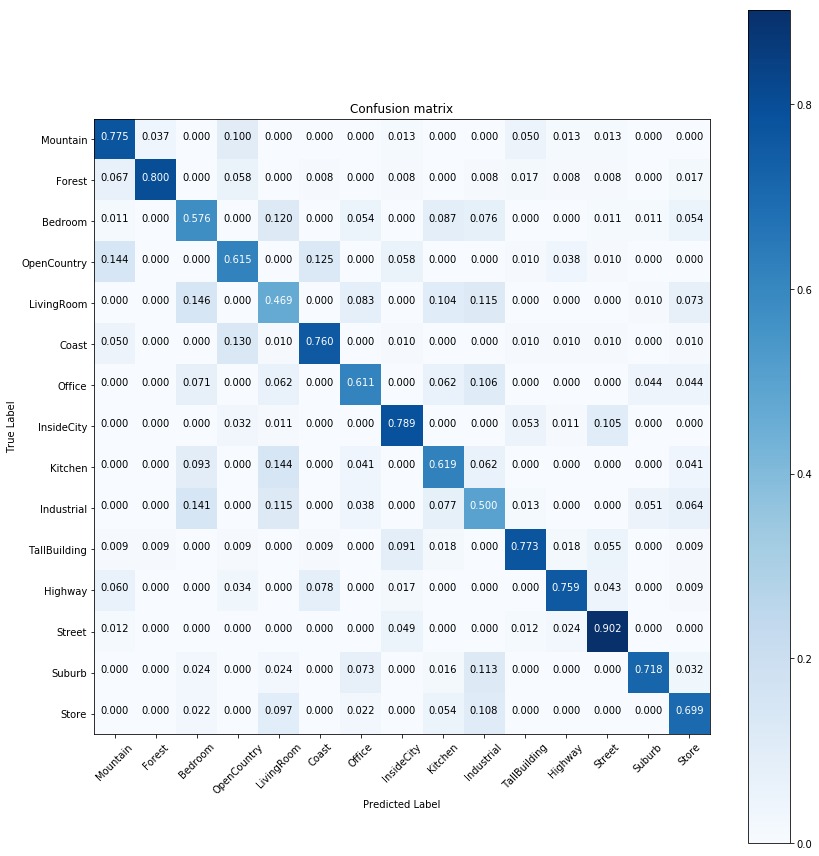

In [9]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    format_num = 'd'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        format_num = '.3f'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_points = np.arange(len(classes))
    plt.xticks(tick_points, classes, rotation=45)
    plt.yticks(tick_points, classes)
    plt.title(title)
    plt.colorbar()
    
    threshold = cm.max()/2.0
    
    for x, y in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(y, x, format(cm[x, y], format_num), horizontalalignment="center",
                 color="white" if cm[x, y] > threshold else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

c_names = [name[11:] for name in glob.glob('data/train/*')]

#First combination:
# Confusion matrix
cm1 = confusion_matrix(pred1, label1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()

#Second combination:
# Confusion matrix
cm2 = confusion_matrix(pred2, label2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(pred3, label3)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>